# Sweet or sour? Local opportunities for new restaurants in Warsaw

## Coursera capstone notebook

The details of what the business problem is, how this data analysis is supposed to resolve it, and what the conclusions are, can be found in the report. Here, the focus is only on the code and what it does to the data.

First, all the necessary imports are performed.

In [1]:
from bs4 import BeautifulSoup #for page scraping
import pandas as pd #for dataframe functionality
import requests #for getting the page
import re #for regular expressions
import numpy as np #for data manipulation functionality
import geocoder #for geocoding
from geopy.geocoders import Nominatim #getting localization
import matplotlib.cm as cm #plotting
import matplotlib.colors as colors #plotting
from sklearn.cluster import KMeans #clustering
import folium # maps
import json #json file handling
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import math #for calculations
from sklearn import preprocessing #for normalization
import matplotlib #plotting
import matplotlib.pyplot as plt #plotting

The analysis is performed district-wise. Therefore, the first step is acquiring data on the districts: their names, population and area. To this goal, a Wikipedia page is utilized as a data soruce. After getting the content of the page, Beautiful Soup is used to get the data out of a table on the page. Then, the data is packed into a Pandas dataframe, that can be previewed below.

In [30]:
link = "https://pl.wikipedia.org/wiki/Podzia%C5%82_administracyjny_Warszawy#Dzielnice_Warszawy"
page_response = requests.get(link, timeout=10)
content = BeautifulSoup(page_response.content, "html.parser")

#getting the data out of an html table
table = content.find('table')
rows = table.find_all('tr')
temp = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.get_text(strip=True) for tr in td]
    temp.append(row)

#building and recomposing the dataframe
df = pd.DataFrame(temp, columns=["District", "Population","PopulationDensity","Area"])
df = df.drop([0],axis=0)
df['District']=df['District'].astype(str)
df['Population']=df['Population'].str.replace(' ', '').astype(int)
df['PopulationDensity']=df['PopulationDensity'].str.replace(' ', '').astype(int)
df['Area']=df['Area'].str.replace(',', '.').astype(float)
df.reset_index(inplace=True,drop=True)
df

,District,Population,PopulationDensity,Area
0,Bemowo,120449,4828,24.95
1,Białołęka,116127,1590,73.04
2,Bielany,131957,4080,32.34
3,Mokotów,217815,6149,35.42
4,Ochota,83592,8600,9.72
5,Praga-Południe,178447,7974,22.38
6,Praga-Północ,65904,5771,11.42
7,Rembertów,24105,1249,19.30
8,Śródmieście,118301,7598,15.57
9,Targówek,123535,5101,24.22


There are no official data on the coordinates of the centres of particular districts available. Therefore, to specify the search areas, the names of the districts are fed into GeoCoder queries to the ArcGIS service and the coordinates are stored in an array. Next, the array is converted into a Pandas dataframe, which is subsequently merged with the Wikipedia data, adding the 'Lat' and 'Long' columns (Latitude and Longitude, respectively). Column 'Radius' is also added. It corresponds to a radius of a disk of the same area as a given district, scaled by a factor of 0.7 (to exclude the outskirts of given districts from the search). This is needed for the 'disk approximation' of the districts for Foursquare queries later.

In [31]:
d=[]
for i in range(0,len(df.index)):
    g = geocoder.arcgis(('{}, Warszawa').format(df.iloc[i]['District']))
    coords=g.latlng
    d.append({'Lat': coords[0], 'Lon': coords[1]})
coordinates = pd.DataFrame(d)

df=pd.concat([df, coordinates], axis=1, join_axes=[df.index])
df['Radius']=((df['Area']/math.pi)**(0.5))*1000*0.7
df

,District,Population,PopulationDensity,Area,Lat,Lon,Radius
0,Bemowo,120449,4828,24.95,52.25269,20.91244,1972.687891
1,Białołęka,116127,1590,73.04,52.31097,20.99324,3375.230881
2,Bielany,131957,4080,32.34,52.27697,20.94778,2245.913944
3,Mokotów,217815,6149,35.42,52.19539,21.00850,2350.430327
4,Ochota,83592,8600,9.72,52.21314,20.97069,1231.278330
5,Praga-Południe,178447,7974,22.38,52.23633,21.09840,1868.328096
6,Praga-Północ,65904,5771,11.42,52.25680,21.02976,1334.615473
7,Rembertów,24105,1249,19.30,52.26579,21.16994,1735.009105
8,Śródmieście,118301,7598,15.57,52.23560,21.01037,1558.358628
9,Targówek,123535,5101,24.22,52.27726,21.06594,1943.614691


To get a visual check on the obtained results, a map of Warsaw is plotted using Folium and the areas corresponding to the districts are superimposed on the maps, together with labelled markers in their centres. 

In [14]:
# get the coordinates of the centre of Warsaw
address = 'Warsaw, Poland'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create a map of Warsaw using latitude and longitude values, with popup labels and circle markers
map_warsaw = folium.Map(location=[latitude, longitude], zoom_start=11)

for Lat, Lon, District, Radius in zip(df['Lat'], df['Lon'], df['District'], df['Radius']):
    label = '{}'.format(District)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([Lat,Lon], 
    popup=label).add_to(map_warsaw)
    folium.Circle([Lat,Lon], 
    radius=Radius,
    fill=True,
    fill_color='blue',
    fill_opacity=0.3).add_to(map_warsaw)
    
map_warsaw

In case the map does not render in the Github preview of the notebook, here's a screenshot of the rendered map:
![title](https://raw.githubusercontent.com/ksozan/Coursera_Capstone/master/folium_map.jpg)

The selected areas correspond to the centres of respective districts and overlap only slightly, while covering most of the inhabitated areas of the city. Their radii correlate with the actual size of the districts.

The groundwork for district-wise analysis has been laid - now, it is time to incorporate the actual data on the eateries of the city. First, a list of 15 invesitgated categories, along with their Foursquare category IDs, is imported from a csv file. The choice of the categories is arbitrary and the file has been composed manually, on the basis of Foursquare documentation. 

In [15]:
url="https://raw.githubusercontent.com/ksozan/Coursera_Capstone/master/categories.csv"
categories=pd.read_csv(url, header=None)
categories.columns=['Category', 'CatID']
categories

,Category,CatID
0,American Restaurant,4bf58dd8d48988d14e941735
1,Asian Restaurant,4bf58dd8d48988d142941735
2,Bakery,4bf58dd8d48988d16a941735
3,Cafe,4bf58dd8d48988d16d941735
4,Coffee Shop,4bf58dd8d48988d1e0931735
5,Dessert Shop,4bf58dd8d48988d1d0941735
6,Fast Food Restaurant,4bf58dd8d48988d16e941735
7,French Restaurant,4bf58dd8d48988d10c941735
8,Italian Restaurant,4bf58dd8d48988d110941735
9,Kebab Restaurant,5283c7b4e4b094cb91ec88d7


Notably, the full Foursquare category list embraces hundreds of entries and can be obtained as a json file from Foursqare website as well as through their API. The subsequent code is written in a way allowing for any chosen number of categories that can be put in the 'categories' dataframe and will work, so long as the columns of the dataframes are formatted properly. Due to the API limitations, in this analysis only a very short list of 15 locally popular categories is taken into account.

Foursquare credentials are established and a test call to the API is performed to get 15 restaurants from around the city centre.

In [17]:
CLIENT_ID = '###' # Foursquare ID -- removed for public submission
CLIENT_SECRET = '###' # Foursquare Secret -- removed for public submission
VERSION = '20180605' # Foursquare API version

In [18]:
LIMIT=15 # in a test call, we only want a short list 
catID='4d4b7105d754a06374d81259' #General food category
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, #city center coordiates
            longitude, 
            Radius, 
            LIMIT,
            catID)
results = requests.get(url).json()
venues = results['response']['venues']
local_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['name', 'location.lat', 'location.lng'] #filter columns to only show the name and coordinates
local_venues = local_venues.loc[:, filtered_columns]
local_venues #show the results as a dataframe 

,name,location.lat,location.lng
0,Hard Rock Cafe Warsaw,52.230041,21.003797
1,Bułkę przez Bibułkę,52.232723,21.014007
2,McDonald's,52.235214,21.009380
3,Green Caffè Nero,52.228728,21.012632
4,AïOLI,52.235924,21.011700
5,Green Caffè Nero,52.235738,21.018286
6,Charlotte Menora,52.235657,21.004140
7,Etno Cafe Marszałkowska,52.227118,21.013234
8,Starbucks Reserve,52.236006,21.018315
9,McDonald's,52.237091,21.018678


The API call retrieves the desired results. For further analysis, only the information about the number of places of certain category in a given district will be needed. First, a dataframe 'places' is created that will hold these values. Next, a nested loop is performed, with Foursquare queries returning venue data. The outer loop goes through venue categories, the inner - through districts. The number of hits is retrieved and stored in the 'places' dataframe. Unfortunately, a limit of 50 results per call is imposed by the Foursuqare regulations. However, only for few districy-venue type pairs this limit is reached.

In [16]:
places = pd.DataFrame(index=categories['Category'],columns=df['District'])

In [19]:
LIMIT=50
for i in range(0,len(categories.index)):
    catID=categories.iloc[i]['CatID']
    for j in range(0,len(df.index)):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            df.iloc[j]['Lat'], 
            df.iloc[j]['Lon'], 
            df.iloc[j]['Radius'], 
            LIMIT,
            catID)
        results = requests.get(url).json()
        venues = results['response']['venues']
        local_venues = json_normalize(venues) # flatten JSON
        places.iloc[i][j]=local_venues.shape[0]
        j=j+1

Due to large variations in the area and population between the districts, direct analysis of the number of venues would not be conclusive. Instead, the obtained venue counts are scaled by the area of the disk-approximation of the district (i.e. the actual search area that they come from) and the population density in the district. In this way, an estimate of the number of venues of given type per 1000 inhabitants of the district is generated. 

In [22]:
places_scaled=places/(math.pi*(df.values[:,6]/1000)**2*df.values[:,2])*1000 #Places of a given type per 1000 citizens

Naturally, the base demand differs between the venue types (i.e. we may expect that more pizza places are needed per 1000 people than american restaurants, which are not as popular in Poland). Therefore, the scales results need to be normalized. For each venue type, normalization across the districts is performed in a way that for the district with highest venue count/1000 inhabitants a value of 1.0 is returned. In this way, relative saturation of the local markets can be estimated. 

In [23]:
x = places_scaled.values.astype(float) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

#normalization needs to be done for each venue type - thus, it is done on a transposed table, and the result is transposed back
x_scaled = (min_max_scaler.fit_transform(x.T)).T 
places_norm = pd.DataFrame(x_scaled, columns=places.columns, index=places.index).round(2)
places_norm

District,Bemowo,Białołęka,Bielany,Mokotów,Ochota,Praga-Południe,Praga-Północ,Rembertów,Śródmieście,Targówek,Ursus,Ursynów,Wawer,Wesoła,Wilanów,Włochy,Wola,Żoliborz
Category,,,,,,,,,,,,,,,,,,
American Restaurant,0.20,0.21,0.07,0.20,0.29,0.06,0.07,0.00,1.00,0.16,0.08,0.30,0.33,0.00,0.16,0.48,0.32,0.10
Asian Restaurant,0.16,0.22,0.27,0.16,0.38,0.18,0.28,0.00,0.33,0.07,0.17,0.25,0.24,0.07,1.00,0.98,0.27,0.44
Bakery,0.22,0.16,0.56,0.37,0.25,0.27,0.65,0.14,0.69,0.08,0.14,0.54,0.35,0.00,0.26,0.55,0.59,1.00
Cafe,0.11,0.10,0.24,0.16,0.34,0.14,0.62,0.00,0.33,0.05,0.07,0.25,0.18,0.14,1.00,0.77,0.27,0.47
Coffee Shop,0.10,0.14,0.23,0.52,0.37,0.15,0.39,0.00,1.00,0.00,0.12,0.27,0.09,0.00,0.68,0.63,0.48,0.42
Dessert Shop,0.18,0.14,0.24,0.27,0.40,0.20,0.43,0.01,0.56,0.00,0.20,0.43,0.24,0.07,1.00,0.82,0.38,0.55
Fast Food Restaurant,0.25,0.30,0.17,0.38,0.59,0.29,0.64,0.00,1.00,0.06,0.17,0.33,0.36,0.30,0.55,0.95,0.32,0.24
French Restaurant,0.11,0.00,0.05,0.21,0.16,0.00,0.20,0.00,1.00,0.05,0.00,0.13,0.00,0.00,0.00,0.32,0.24,0.26
Italian Restaurant,0.17,0.06,0.14,0.34,0.30,0.18,0.10,0.00,0.95,0.04,0.08,0.38,0.15,0.18,1.00,0.49,0.31,0.40


The obtained results are visualised on a heatmap, using Matplotlib.

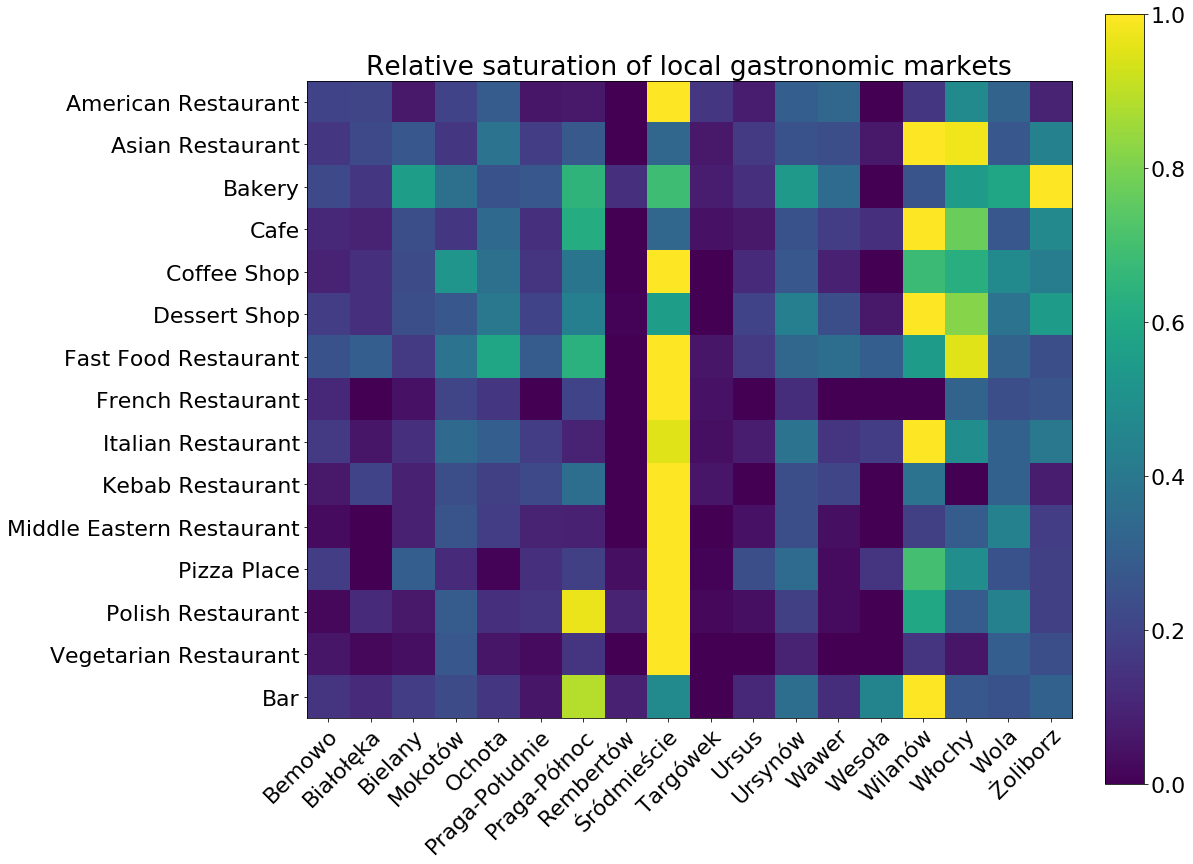

In [32]:
norm = places_norm.values
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(norm)

matplotlib.rcParams.update({'font.size': 22})

plt.colorbar(im,fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(df.index)))
ax.set_yticks(np.arange(len(categories.index)))

ax.set_xticklabels(list(places_norm))
ax.set_yticklabels(places_norm.index.tolist())

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Relative saturation of local gastronomic markets")
plt.show()

As can be seen in the heatmap, for most venue categories a single district is by far dominating the results, which is Śródmieście, i.e. city centre. Being home to many workplaces, cultural institutions, and hotels, as well as a hub for foot traffic and public transport -- while not embracing too many housings -- it can be expected to have a demand for restaurants much higher than would be justified by its officialy registered population. Since in this analysis we only have access to the data on permanent inhabitants of the districts (and not on the daily number of passer-by's, for instance), the city centre may skew the results strongly. Also, due to shortage of space for rent, high rent costs and huge competition, it is a very specific target for restaurant enterpreneurs, that evades simple analytical approach presented here. Therefore, it is recommendable to rerun the normalization and visualisation on a dataset excluding the city centre.

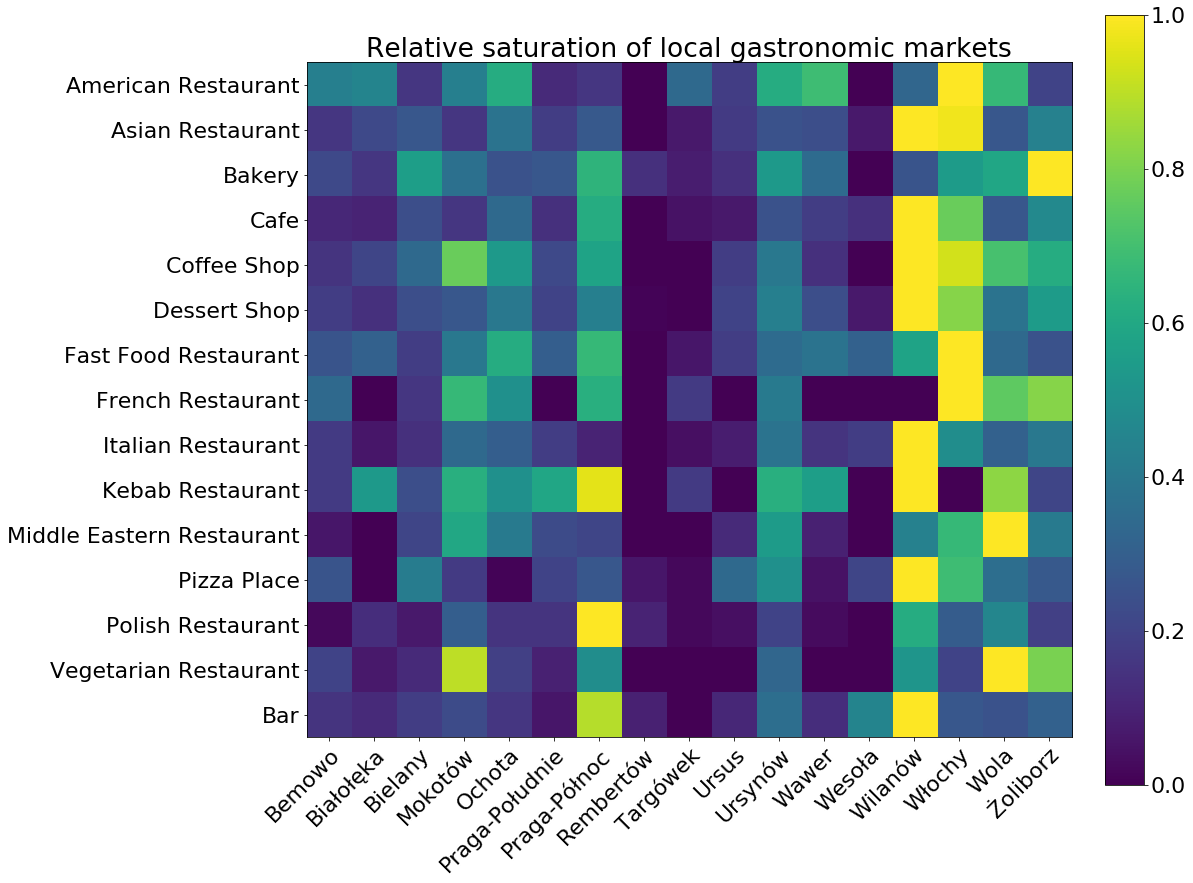

In [29]:
places_scaled_noCentre = places_scaled.drop(['Śródmieście'],axis=1)
y = places_scaled_noCentre.values.astype(float) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = (min_max_scaler.fit_transform(y.T)).T
places_norm_noCentre = pd.DataFrame(y_scaled, columns=places_scaled_noCentre.columns, index=places.index).round(2)
places_norm_noCentre

norm_noCentre = places_norm_noCentre.values
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(norm_noCentre)

matplotlib.rcParams.update({'font.size': 22})

plt.colorbar(im,fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(places_scaled_noCentre.columns)))
ax.set_yticks(np.arange(len(categories.index)))

ax.set_xticklabels(list(places_norm_noCentre))
ax.set_yticklabels(places_norm.index.tolist())

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Relative saturation of local gastronomic markets")
plt.show()